# Looking at SKM-TEA Data

In [1]:
# Imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os
import json
import pandas as pd

In [2]:
# Function to normalise an array to between 0 and 1.
# Upper bound to clip to can be provided.
def clip_and_norm(image, upper_bound=None):
    # Clip intensity values
    if upper_bound==None:
        upper_bound=np.max(image)
    
    image = np.clip(image, 0, upper_bound)

    # Normalize the image to the range [0, 1]
    norm = (image - 0) / (upper_bound - 0)

    return norm

## Read In Image

In [7]:
# Path to .h5 dicom data
dir_path = '../../../qdess/v1-release/image_files/'

# Path to example .h5 file
file_path = dir_path + 'MTR_005.h5'

In [10]:
# Open the HDF5 file in read mode
with h5py.File(file_path, 'r') as h5_file:
    # Load Echo 1 and Echo 2 data
    echo1 = h5_file['echo1'][:].astype(np.float32)  # Shape: (X, Y, Z)
    echo2 = h5_file['echo2'][:].astype(np.float32) # Shape: (X, Y, Z)
    
    # Load segmentation data (One-hot encoded, 6 classes)
    seg = h5_file['seg'][:]      # Shape: (X, Y, Z, 6)
    
    # compute RSS
    rss = np.sqrt(echo1**2 + echo2**2)

    # Display loaded data dimensions and some statistics
    print(f"Echo 1 shape: {echo1.shape}")
    print(f"Echo 2 shape: {echo2.shape}")
    print(f"Segmentation shape: {seg.shape}")
    print(f"Statistics for Echo 1: Mean={np.mean(echo1)}, Std={np.std(echo1)}, Min={np.min(echo1)}, Max={np.max(echo1)}")
    print(f"Statistics for Echo 2: Mean={np.mean(echo2)}, Std={np.std(echo2)}, Min={np.min(echo2)}, Max={np.max(echo2)}")
    print(f"Statistics for RSS: Mean={np.mean(rss)}, Std={np.std(rss)}, Min={np.min(rss)}, Max={np.max(rss)}")

Echo 1 shape: (512, 512, 160)
Echo 2 shape: (512, 512, 160)
Segmentation shape: (512, 512, 160, 6)
Statistics for Echo 1: Mean=469.112548828125, Std=524.0570678710938, Min=0.0, Max=5068.0
Statistics for Echo 2: Mean=198.35887145996094, Std=149.17515563964844, Min=0.0, Max=4540.0
Statistics for RSS: Mean=523.124755859375, Std=531.6414794921875, Min=0.0, Max=6804.1328125


In [5]:
# Normalise echos to between 0 and 1
echo1 = clip_and_norm(echo1)
echo2 = clip_and_norm(echo2)

# Compute the RSS
rss = np.sqrt(echo1**2 + echo2**2)

## Look at Echos and RSS

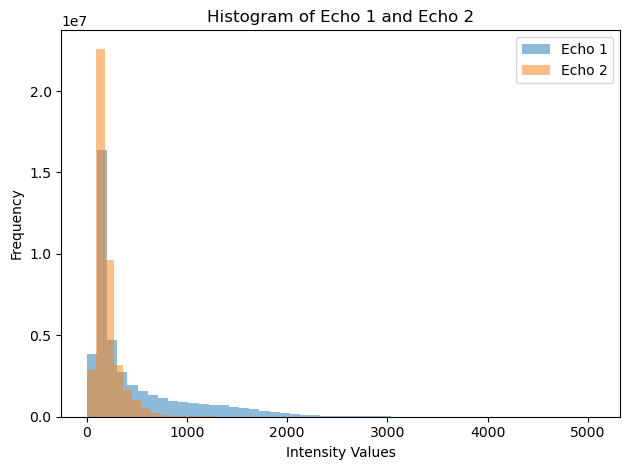

In [11]:
# Plot histograms to see the data distribution
plt.hist(echo1.flatten(), bins=50, alpha=0.5, label='Echo 1')
plt.hist(echo2.flatten(), bins=50, alpha=0.5, label='Echo 2')
plt.legend()
plt.title("Histogram of Echo 1 and Echo 2")
plt.xlabel("Intensity Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("normalised_echos.png", dpi=300, bbox_inches="tight")

plt.show()

In [7]:
# Clip echos
echo1 = clip_and_norm(echo1, 0.6)
echo2 = clip_and_norm(echo2, 0.2)

# Compute the RSS of clipped echos
rss_of_clipped = np.sqrt(echo1**2 + echo2**2)

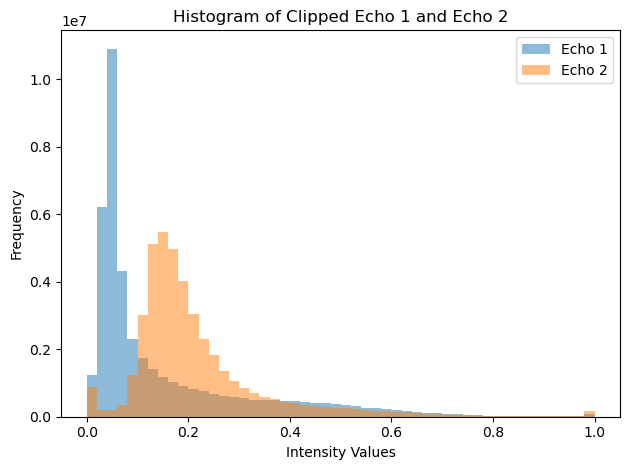

In [8]:
# Look at clipped echos
plt.hist(echo1.flatten(), bins=50, alpha=0.5, label='Echo 1')
plt.hist(echo2.flatten(), bins=50, alpha=0.5, label='Echo 2')
plt.legend()
plt.title("Histogram of Clipped Echo 1 and Echo 2")
plt.xlabel("Intensity Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("clipped_echos.png", dpi=300, bbox_inches="tight")

plt.show()

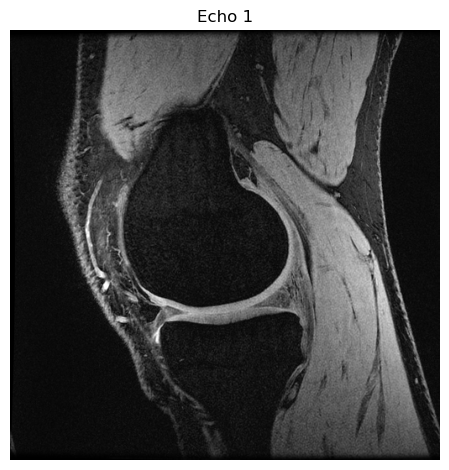

In [9]:
slicenum=100
plt.imshow(echo1[:,:,slicenum], cmap='gray')
plt.title("Echo 1")
plt.axis('off')
plt.tight_layout()
plt.savefig("echo1.png", dpi=300, bbox_inches="tight")

plt.show()

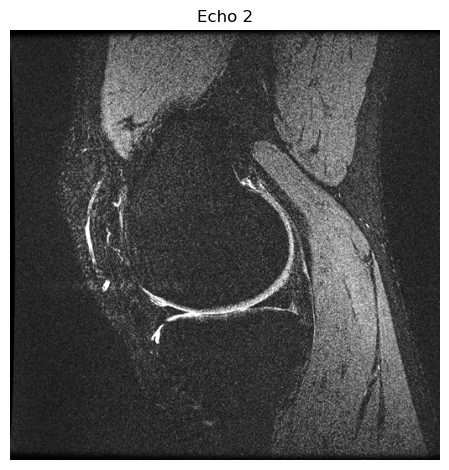

In [10]:
plt.imshow(echo2[:,:,slicenum], cmap='gray')
plt.title("Echo 2")
plt.axis('off')
plt.tight_layout()
plt.savefig("echo2.png", dpi=300, bbox_inches="tight")

plt.show()

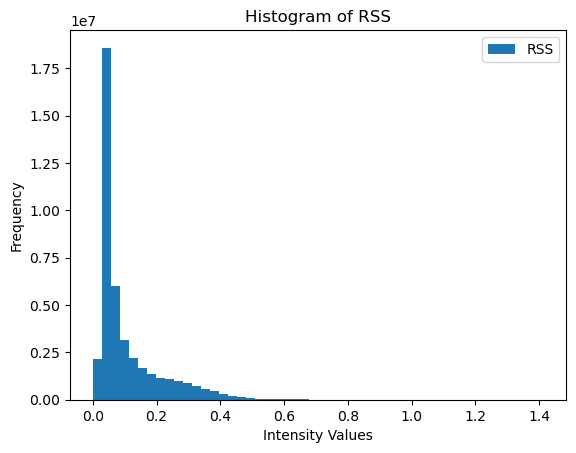

In [11]:
plt.hist(rss.flatten(), bins=50, label='RSS')
plt.legend()
plt.title("Histogram of RSS")
plt.xlabel("Intensity Values")
plt.ylabel("Frequency")
plt.show()

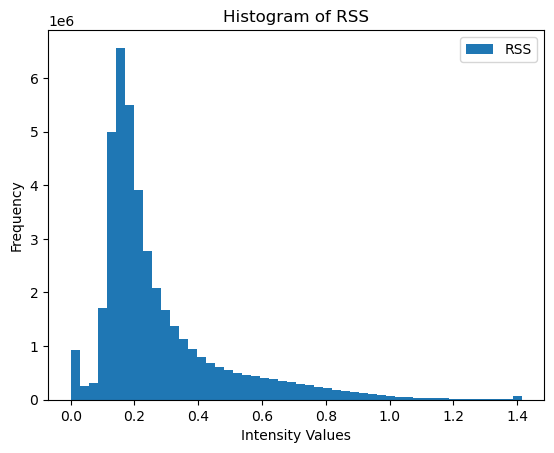

In [12]:
plt.hist(rss_of_clipped.flatten(), bins=50, label='RSS')
plt.legend()
plt.title("Histogram of RSS")
plt.xlabel("Intensity Values")
plt.ylabel("Frequency")
plt.show()

In [13]:
norm_clipped_rss = clip_and_norm(rss, 0.6)
norm_rss_of_clipped = clip_and_norm(rss_of_clipped)

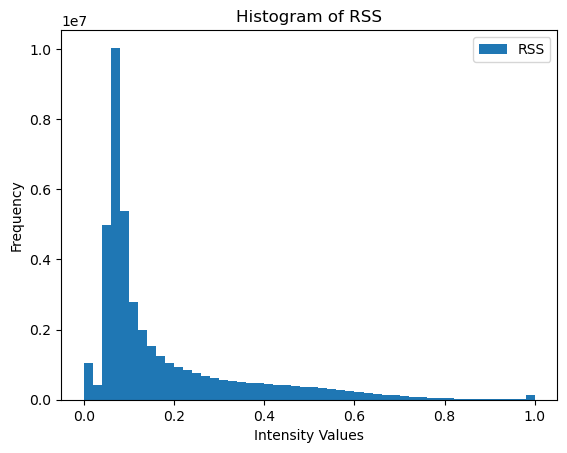

In [14]:
plt.hist(norm_clipped_rss.flatten(), bins=50, label='RSS')
plt.legend()
plt.title("Histogram of RSS")
plt.xlabel("Intensity Values")
plt.ylabel("Frequency")
plt.show()

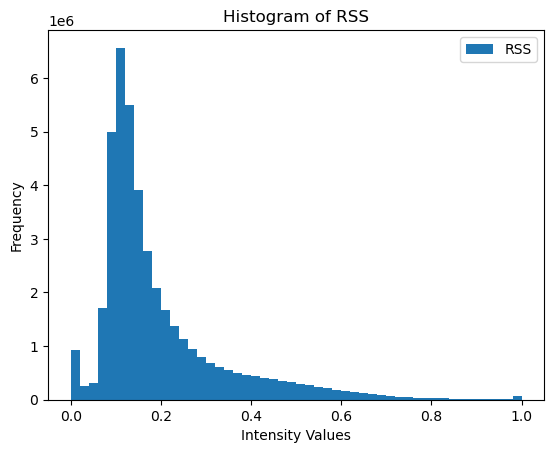

In [15]:
plt.hist(norm_rss_of_clipped.flatten(), bins=50, label='RSS')
plt.legend()
plt.title("Histogram of RSS")
plt.xlabel("Intensity Values")
plt.ylabel("Frequency")
plt.show()

## Plot RSS image using unclipped and clipped echos

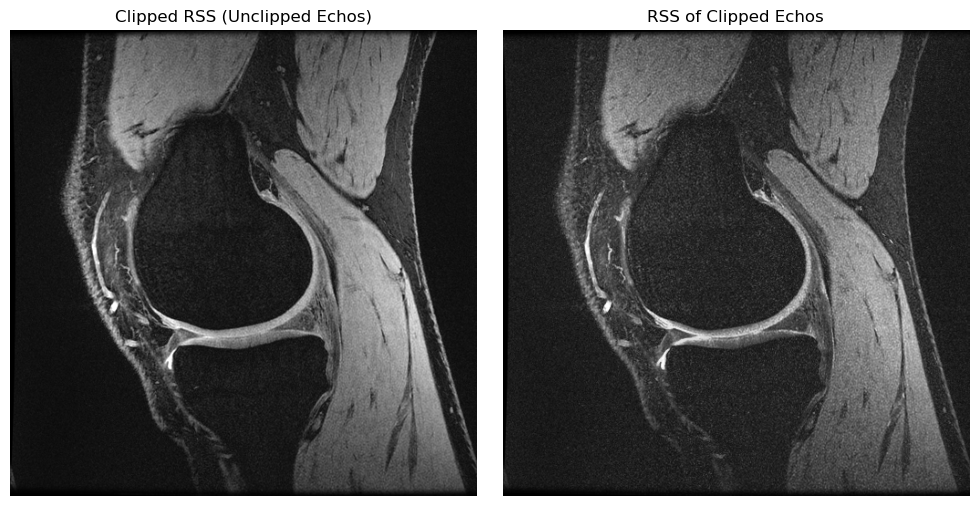

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(norm_clipped_rss[:, :, slicenum], cmap='gray')
ax[0].set_title("Clipped RSS (Unclipped Echos)")
ax[0].axis("off")

ax[1].imshow(norm_rss_of_clipped[:, :, slicenum], cmap='gray')
ax[1].set_title("RSS of Clipped Echos")
ax[1].axis("off")

plt.tight_layout()
plt.savefig("rss_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

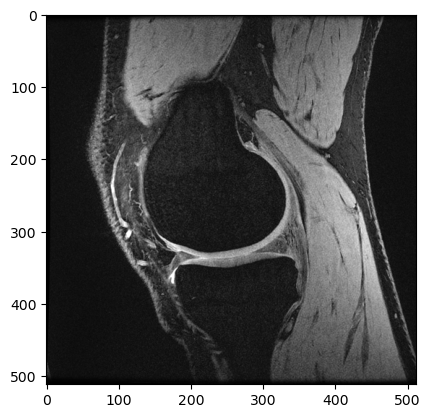

In [17]:
plt.imshow(norm_clipped_rss[...,slicenum], cmap='gray')
plt.show()

In [18]:
import torch

data_tensor = torch.tensor(norm_clipped_rss).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 512, 512, 160)
# Resize the image using trilinear interpolation
resized_tensor = torch.nn.functional.interpolate(data_tensor, size=(384, 384, 160), mode='trilinear', align_corners=True)

In [19]:
resized_tensor.shape

torch.Size([1, 1, 384, 384, 160])

In [20]:
resized_im = resized_tensor.squeeze(0).squeeze(0).numpy()

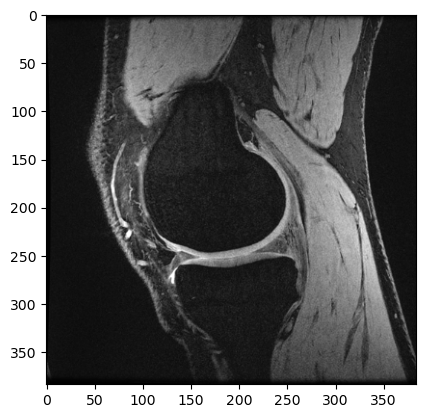

In [21]:
plt.imshow(resized_im[...,slicenum], cmap='gray')
plt.show()

## Look at Segmentation Masks

In [22]:
med = seg[:,:,:,4]
lat = seg[:,:,:,5]
menisc = med + lat

h, w, d = med.shape

In [23]:
# Create an empty RGB image
rgb_image = np.zeros((h, w, d, 3), dtype=np.uint8)

# Assign the red channel (mask_red) and blue channel (mask_blue)
rgb_image[..., 0] = med   # Red channel
rgb_image[..., 2] = lat   # Blue channel

In [24]:
rgb_proj = np.sum(rgb_image, axis=0)
np.max(rgb_proj)

25

In [25]:
rgb_proj = (rgb_proj * (255/np.max(rgb_proj))).astype(int)

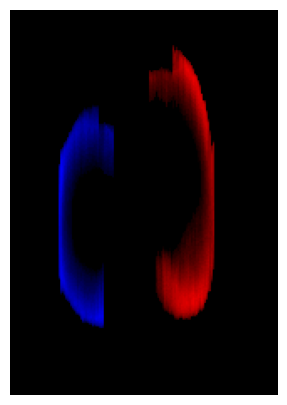

In [26]:
plt.figure(figsize=(5,5))
plt.imshow(rgb_proj[150:380,...])
plt.axis('off')

plt.show()

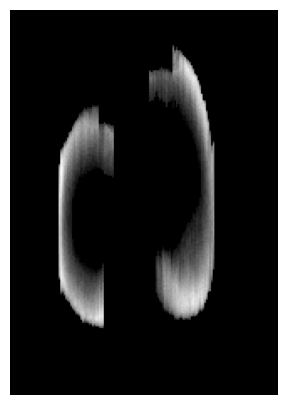

In [27]:
plt.figure(figsize=(5,5))
plt.imshow(np.sum(menisc, axis=0)[150:380,...], cmap='gray')
plt.axis('off')

plt.show()

## Look At Annotations

In [28]:
# annotations path
ann_dir_path = 'qdess/v1-release/annotations/v1.0.0/'

# Path to the JSON file
file_path = "train.json"

# Open and load the JSON file
with open(ann_dir_path + file_path, "r") as file:
    data = json.load(file)

# Access each part of the JSON structure
info = data["info"]
categories = data["categories"]
images = data["images"]
annotations = data["annotations"]

In [29]:
info

{'contributor': 'Arjun Desai, Elka Rubin, Andrew Schmidt, Akshay Chaudhari & collaborators',
 'description': '2021 SKM-TEA Dataset - train',
 'year': '2021',
 'date_created': '2021-08-23 14:05:06 PST',
 'version': 'v1.0.0'}

In [30]:
categories[0]

{'supercategory': 'Meniscal Tear',
 'supercategory_id': 1,
 'id': 1,
 'name': 'Meniscal Tear (Myxoid)'}

In [31]:
# as a dataframe
categories_df = pd.DataFrame(categories)

In [32]:
categories_df

supercategory  supercategory_id  id  \
0      Meniscal Tear                 1   1   
1      Meniscal Tear                 1   2   
2      Meniscal Tear                 1   3   
3      Meniscal Tear                 1   4   
4      Meniscal Tear                 1   5   
5      Meniscal Tear                 1   6   
6      Meniscal Tear                 1   7   
7      Meniscal Tear                 1   8   
8      Ligament Tear                 2   9   
9      Ligament Tear                 2  10   
10     Ligament Tear                 2  11   
11  Cartilage Lesion                 3  12   
12  Cartilage Lesion                 3  13   
13  Cartilage Lesion                 3  14   
14  Cartilage Lesion                 3  15   
15          Effusion                 4  16   

                                                 name  
0                              Meniscal Tear (Myxoid)  
1                          Meniscal Tear (Horizontal)  
2                              Meniscal Tear (Radial)  
3               Meniscal Tear (Vertical/Longitudinal)  
4                             Meniscal Tear (Oblique)  
5                             Meniscal Tear (Complex)  
6                                Meniscal Tear (Flap)  
7                           Meniscal Tear (Extrusion)  
8                    Ligament Tear (Low-Grade Sprain)  
9   Ligament Tear (Moderate Grade Sprain or Mucoid...  
10       Ligament Tear (Full Thickness/Complete Tear)  
11                               Cartilage Lesion (1)  
12                              Cartilage Lesion (2A)  
13                              Cartilage Lesion (2B)  
14                               Cartilage Lesion (3)  
15                                           Effusion

In [33]:
# Mapping dictionaries for cross-referencing
id_to_name = dict(zip(categories_df["id"], categories_df["name"]))
id_to_supercategory = dict(zip(categories_df["id"], categories_df["supercategory"]))

In [34]:
id_to_name.get(1)

'Meniscal Tear (Myxoid)'

In [35]:
images_df = pd.DataFrame(images)

In [36]:
images_df.head()

id   file_name       msp_id   msp_file_name  scan_id  subject_id  \
0   1  MTR_001.h5  0000079_V00  0000079_V00.h5  MTR_001          79   
1   2  MTR_008.h5  0000260_V00  0000260_V00.h5  MTR_008         260   
2   3  MTR_010.h5  0000165_V00  0000165_V00.h5  MTR_010         165   
3   4  MTR_015.h5  0000232_V00  0000232_V00.h5  MTR_015         232   
4   5  MTR_016.h5  0000228_V00  0000228_V00.h5  MTR_016         228   

   timepoint          voxel_spacing     matrix_shape   orientation  \
0          0  [0.3125, 0.3125, 0.8]  [512, 512, 160]  [SI, AP, LR]   
1          0  [0.3125, 0.3125, 0.8]  [512, 512, 160]  [SI, AP, LR]   
2          0  [0.3125, 0.3125, 0.8]  [512, 512, 160]  [SI, AP, LR]   
3          0  [0.3125, 0.3125, 0.8]  [512, 512, 160]  [SI, AP, LR]   
4          0  [0.3125, 0.3125, 0.8]  [512, 512, 160]  [SI, AP, LR]   

   num_echoes  inspected  
0           2       True  
1           2       True  
2           2       True  
3           2       True  
4           2       True

In [37]:
# Mapping dictionaries for cross-referencing filename from imageid
id_to_filename = dict(zip(images_df["id"], images_df["file_name"]))

## Now look at a particular pathology case as example

In [38]:
annotations[0]

{'id': 1,
 'image_id': 31,
 'category_id': 3,
 'tissue_id': 1,
 'bbox': [330.0, 232.0, 54.0, 5.0, 19.0, 10.0],
 'confidence': 3.0,
 'labeler': 1}

In [39]:
anns_df = pd.DataFrame(annotations)

In [40]:
anns_df.head()

id  image_id  category_id  tissue_id  \
0   1        31            3          1   
1   2        31           12          4   
2   3        31           13          4   
3   4        32           16         -1   
4   5        32            2          1   

                                       bbox  confidence  labeler  
0     [330.0, 232.0, 54.0, 5.0, 19.0, 10.0]         3.0        1  
1    [227.0, 156.0, 55.0, 20.0, 12.0, 13.0]         4.0        1  
2    [246.0, 166.0, 92.0, 63.0, 23.0, 17.0]         4.0        1  
3  [45.0, 109.0, 30.0, 264.0, 121.0, 107.0]         5.0        1  
4      [322.0, 216.0, 42.0, 4.0, 11.0, 8.0]         3.0        1

In [41]:
# Look at tissue types (Note that meniscus is 1)
data['tissues']

[{'id': 1, 'name': 'Meniscus'},
 {'id': 2, 'name': 'ACL'},
 {'id': 3, 'name': 'PCL'},
 {'id': 4, 'name': 'Femoral Cartilage'},
 {'id': 5, 'name': 'Patellar Cartilage'},
 {'id': 6, 'name': 'Tibial Cartilage'}]

In [42]:
# filter by meniscus
menisc_anns_df = anns_df[anns_df['tissue_id'] == 1]

In [43]:
# Show highest conf meniscus annotations
menisc_anns_df[menisc_anns_df['confidence'] > 3]

id  image_id  category_id  tissue_id  \
13    14        64            8          1   
51    52        18            8          1   
64    65         8            2          1   
72    73        11            8          1   
84    85        26            8          1   
150  151        66            8          1   

                                        bbox  confidence  labeler  
13    [341.0, 241.0, 25.0, 12.0, 63.0, 37.0]         4.0        1  
51   [243.0, 186.0, 36.0, 34.0, 114.0, 48.0]         4.0        1  
64    [323.0, 341.0, 127.0, 8.0, 16.0, 10.0]         4.0        1  
72    [266.0, 176.0, 57.0, 31.0, 98.0, 49.0]         4.0        1  
84    [274.0, 185.0, 45.0, 25.0, 90.0, 34.0]         4.0        1  
150   [303.0, 162.0, 34.0, 28.0, 85.0, 31.0]         4.0        2

In [44]:
# take first row as example
example_ann = menisc_anns_df[menisc_anns_df['confidence'] > 3].iloc[0]

In [45]:
example_ann

id                                                 14
image_id                                           64
category_id                                         8
tissue_id                                           1
bbox           [341.0, 241.0, 25.0, 12.0, 63.0, 37.0]
confidence                                        4.0
labeler                                             1
Name: 13, dtype: object

In [46]:
# annotation type
id_to_name.get(example_ann['category_id'])

'Meniscal Tear (Extrusion)'

In [47]:
# image filename
(image_filename := id_to_filename.get(example_ann['image_id']))

'MTR_194.h5'

In [48]:
# Path to .h5 file
image_path = dir_path + image_filename

In [49]:
# Open the HDF5 file in read mode
with h5py.File(image_path, 'r') as h5_file:
    # Load Echo 1 and Echo 2 data
    echo1 = h5_file['echo1'][:].astype(np.float64)  # Shape: (X, Y, Z)
    echo2 = h5_file['echo2'][:].astype(np.float64) # Shape: (X, Y, Z)
    
    # Load segmentation data (One-hot encoded, 6 classes)
    seg = h5_file['seg'][:]      # Shape: (X, Y, Z, 6)

In [50]:
# Normalise echos to between 0 and 1
echo1 = clip_and_norm(echo1)
echo2 = clip_and_norm(echo2)

# Compute the RSS
rss = np.sqrt(echo1**2 + echo2**2)

# clip and norm RSS as before
preproc_rss = clip_and_norm(rss, 0.6)

In [51]:
example_ann['bbox']

[341.0, 241.0, 25.0, 12.0, 63.0, 37.0]

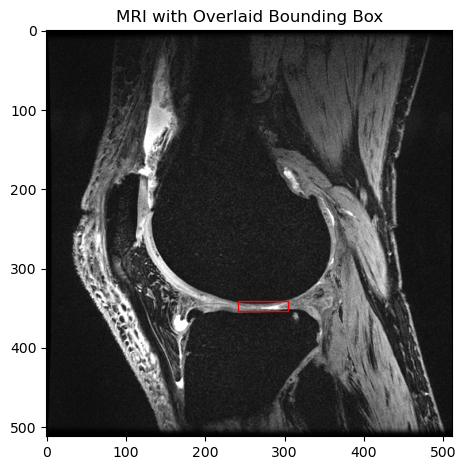

In [52]:
# show mri along with pathology bbox
import matplotlib.patches as patches

x_min, y_min, z_min, width, height, depth = example_ann['bbox']

slicenum = int(z_min + (depth / 2))  # Midpoint in the z-direction

plt.imshow(preproc_rss[:,:,slicenum], cmap='gray')
plt.title("MRI with Overlaid Bounding Box")
#plt.axis('off')

# Create a rectangle patch for the bounding box
rect = patches.Rectangle((y_min, x_min), height, width, linewidth=1, edgecolor='red', facecolor='none')

# Add the patch to the plot
plt.gca().add_patch(rect)

plt.tight_layout()
#plt.savefig("overlaid_bbox2.png", dpi=300, bbox_inches="tight")

plt.show()

(32, 83)


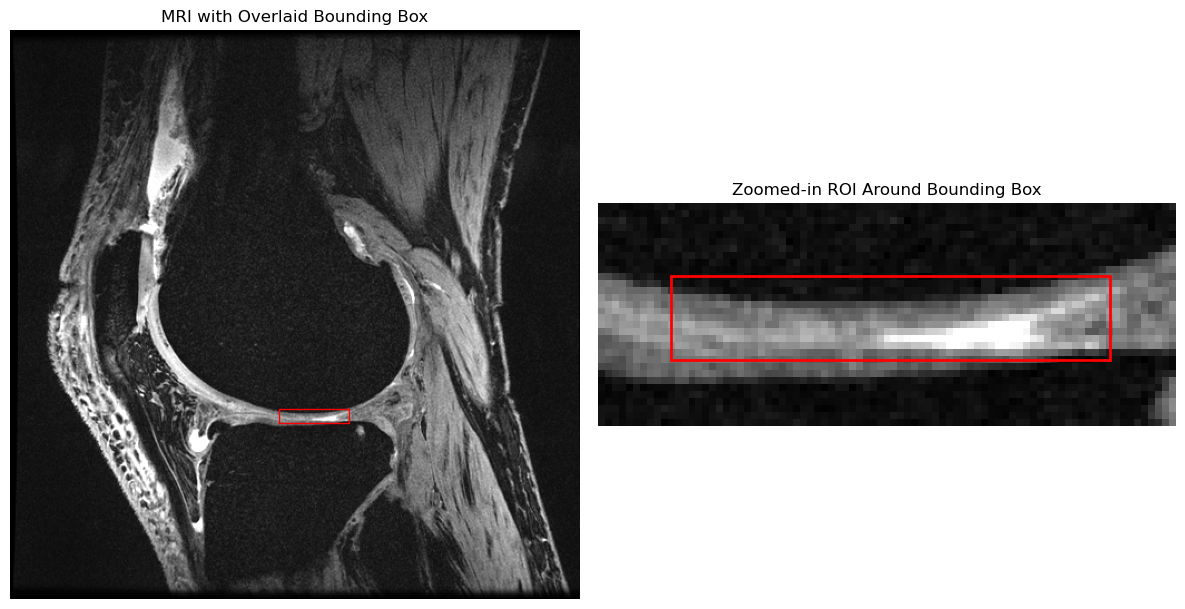

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the bounding box parameters
y_min, x_min, z_min, height, width, depth = example_ann['bbox']

# Set the slice number to the midpoint of the z dimension
slicenum = int(z_min + (depth / 2))  # Midpoint in the z-direction

# Show the original MRI slice with the bounding box
plt.figure(figsize=(12, 6))

# Original MRI slice
plt.subplot(1, 2, 1)
plt.imshow(preproc_rss[:, :, slicenum], cmap='gray')
plt.title("MRI with Overlaid Bounding Box")

# Create a rectangle patch for the bounding box
rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='red', facecolor='none')

# Add the bounding box patch to the plot
plt.gca().add_patch(rect)
plt.axis('off')

# Define a leeway around the bounding box for zooming in
leeway = 10  # Adjust this value as needed

# Define the zoomed-in region
x_min_zoom = max(0, int(x_min - leeway))
y_min_zoom = max(0, int(y_min - leeway))
x_max_zoom = min(preproc_rss.shape[1], int(x_min + width + leeway))
y_max_zoom = min(preproc_rss.shape[0], int(y_min + height + leeway))

# Extract the zoomed-in region from the MRI slice
zoomed_roi = preproc_rss[y_min_zoom:y_max_zoom, x_min_zoom:x_max_zoom, slicenum]

print(zoomed_roi.shape)

# Zoomed-in plot
plt.subplot(1, 2, 2)
plt.imshow(zoomed_roi, cmap='gray')
plt.title("Zoomed-in ROI Around Bounding Box")
plt.axis('off')

# Create a rectangle for the bounding box in the zoomed-in plot
zoomed_rect = patches.Rectangle((leeway, leeway), width, height,
                                linewidth=2, edgecolor='red', facecolor='none')

# Add the bounding box to the zoomed-in plot
plt.gca().add_patch(zoomed_rect)

# Final adjustments and saving
plt.tight_layout()
plt.savefig("overlaid_bbox_zoomed.png", dpi=300, bbox_inches="tight")
plt.show()

## Compare to OAI image

In [54]:
os.getcwd()

'/Volumes/My Book Duo/skmtea'

In [62]:
oai_dir_path = '../test_OAI_im/dicom_series/'

In [63]:
oai_image = np.zeros((384, 384, 160))

for i in range(160):
    slice_num = str(i+1).zfill(3)
    ds = pydicom.dcmread(oai_dir_path + slice_num)
    oai_slice = ds.pixel_array
    oai_image[:,:,i] = oai_slice

In [64]:
import SimpleITK as sitk
import os

# Use the ImageSeriesReader to read the DICOM series
reader = sitk.ImageSeriesReader()

# Get the list of file names for the DICOM series
dicom_series = reader.GetGDCMSeriesFileNames(oai_dir_path)

# Set the file names for the reader
reader.SetFileNames(dicom_series)

# Load the DICOM series as a 3D image
volume_3d = reader.Execute()

# Now `volume_3d` is a 3D SimpleITK image with pixel spacing and slice thickness set correctly
# You can check the spacing and other metadata like this:
print("Image size:", volume_3d.GetSize())
print("Spacing (x, y, z):", volume_3d.GetSpacing())  # Includes pixel spacing and slice thickness
print("Origin:", volume_3d.GetOrigin())
print("Direction:", volume_3d.GetDirection())

# Save or process `volume_3d` as needed
sitk.WriteImage(volume_3d, "output_3d_volume.nii.gz")

Image size: (384, 384, 160)
Spacing (x, y, z): (0.36458333, 0.36458333, 0.6999999827242422)
Origin: (-31.153329, -81.383655, 70.0)
Direction: (0.2419219106304042, 0.0, -0.970295722528413, 0.970295722528413, 0.0, 0.2419219106304042, 0.0, -1.0000000000000002, 0.0)


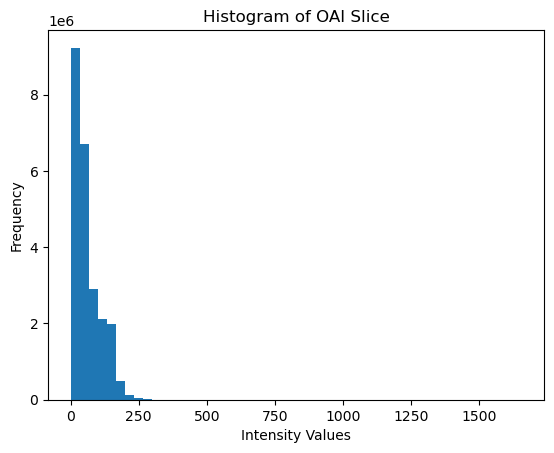

In [124]:
plt.hist(oai_image.flatten(), bins=50)
plt.title("Histogram of OAI Slice")
plt.xlabel("Intensity Values")
plt.ylabel("Frequency")
plt.show()

In [125]:
# Clip OAI image
clipped_oai = clip_and_norm(oai_image, 250)

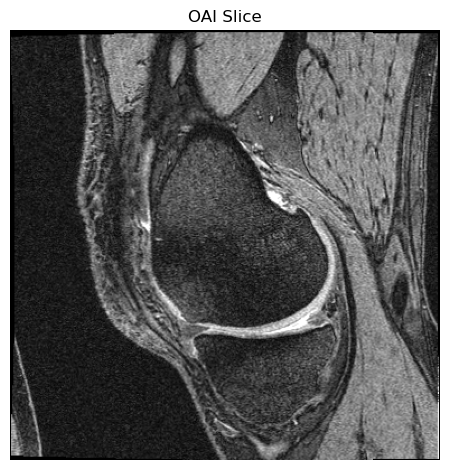

In [146]:
plt.imshow(clipped_oai[:,:,110], cmap='gray')
plt.title("OAI Slice")
plt.axis('off')
plt.tight_layout()
plt.savefig("oai_slice.png", dpi=300, bbox_inches="tight")

plt.show()

In [139]:
oai_slice.shape

(384, 384)